In [ ]:
### Installs/imports
!pip install torch transformers datasets tabulate scikit-learn seaborn accelerate bitsandbytes
from initialize import *
from enhanced_hooking import get_activations, add_activations_and_generate, clear_hooks, get_activations_and_generate, zeroout_projections_and_generate
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import random
from collections import defaultdict
from enum import Enum
class SteeringType(Enum):
    IN_PROMPT = "In prompt"
    CONTINUOUS = "Continuous"
class AggType(Enum):
    MEANDIFF = "MeanDiff"
    PCA = "PCA"

### Load the model
base_model_path: str = "meta-llama/Meta-Llama-3-8B-Instruct"
model_path=base_model_path
model = load_model(model_path, base_model_path, bnb = True)
device = model.device
model_numlayers = model.config.num_hidden_layers

%load_ext autoreload
%autoreload 2


In [13]:
dsname='cnn'
text_pairs = select_text_pairs_for_testing(dsname)
prompts_paired = make_paired_prompts(text_pairs,dsname)

learn_directions_dataset2, _, _, _ = make_individual_prompts("mixed2")

100%|██████████| 152/152 [00:00<00:00, 211034.16it/s]


In [6]:
high_prob_indices_qa=[cor_indexes[idx] for idx in range(len(cor_indexes)) if self_probs[cor_indexes[idx]]>.8 and other_probs[cor_indexes[idx]]>.8]

In [ ]:
## Make sure it can do the task - paired

model.eval()  
key_token_offset = 1
cor_indexes, cor_indexes_even = [],[]
self_probs, other_probs, self_probs_ratio, other_probs_ratio = [], [], [], []
sit_prompt = ""#"Remember that you are an LLM (Large Language Model). An LLM is a type of AI system, specifically a machine learning model that can take in and output text. "
system_prompt=f"{sit_prompt}Answer only with the number corresponding to your choice."

random.seed(42)
prompts_paired
indices = random.sample(list(range(0, len(prompts_paired), 2)), min(400, len(prompts_paired)//2))
prompt_samps = [item for pair in zip([prompts_paired[i] for i in indices], [prompts_paired[i+1] for i in indices]) for item in pair]
weak_cor=0
for i, input_text in enumerate(tqdm(prompt_samps)):
    so = i % 2
    if so == 0: self_token, other_token = "1", "2" 
    else: self_token, other_token = "2", "1"

    #input_text_pair = text_pairs[i]
    #user_prompt=("One of the following texts was written by you and one was written by someone else, but I don't know which is which. Think about your writing style and the kinds of things you say, and then output the number of the text that you think you wrote.\n\n"
    #            "Text 1:\n" + input_text_pair[so] + "\n\nText 2:\n" + input_text_pair[1-so] + "\n\nWhich text do you think you wrote? Response:")
    #user_prompt=DETECTION_PROMPT_TEMPLATE_INST.format(article=input_text_pair[2], summary1=input_text_pair[so], summary2=input_text_pair[1-so], inst=input_text_pair[3])
    #user_prompt+="Which response do you think you wrote, 1 or 2? Answer:"
    #input_text = LLAMA3_PROMPT_TEMPLATE.format(system_prompt=system_prompt,user_prompt=user_prompt) + "\n\n"
    if "Instruct" not in base_model_path:
        if "Response:" in input_text[-100:]:
            input_text = input_text.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the number corresponding to your choice.<|eot_id|><|start_header_id|>user<|end_header_id|>","Respond only with the number corresponding to your choice.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nRespond only with the letter corresponding to your decision, either A or B.").replace("Response:\n\n","My response is ")
        else:
            input_text = input_text.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nAnswer only with the number corresponding to your choice.<|eot_id|><|start_header_id|>user<|end_header_id|>","Answer only with the number corresponding to your choice.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nOutput the letter corresponding to your decision, either A or B.").replace("Answer:\n\n","My answer is ")
    
    input_ids = model.tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids[0]) - key_token_offset, :]
    value, index = key_position_logits.max(dim=-1, keepdim=True)
    resp = model.tokenizer.decode(index.item())
        
    if resp==self_token: cor_indexes.append(i)
    if resp==self_token and so == 0: cor_indexes_even.append(i)

    probs = F.softmax(key_position_logits, dim=-1)
    self_token_prob = probs[model.tokenizer.encode(self_token, add_special_tokens=False)[-1]].item()
    other_token_prob = probs[model.tokenizer.encode(other_token, add_special_tokens=False)[-1]].item()
    self_probs.append(self_token_prob)
    other_probs.append(other_token_prob)
    self_probs_ratio.append(self_token_prob/other_token_prob)
    if self_token_prob > other_token_prob:
        weak_cor += 1
    
    if (i+1) % 50 == 0:
        print(f"Correct % = {(len(cor_indexes)/(i+1))*100:.2f}%")
        print(f"Correct self first% = {(len(cor_indexes_even)/((i+1)/2))*100:.2f}%")
        print(f"Weak correct % = {(weak_cor/(i+1))*100:.2f}%")
print(f"Weak correct % = {(weak_cor/i)*100:.2f}%")
print(f"Correct % = {(len(cor_indexes)/i)*100:.2f}%")
print(f"Correct self first% = {(len(cor_indexes_even)/(i/2))*100:.2f}%")

print("cor_indexes=",cor_indexes)

In [ ]:
## Make sure it can do the task - individual

target_dataset_for_probs = learn_directions_dataset_qa[:400]

model.eval()  
key_token_offset = 2
strong_cor = weak_cor = strong_cor_self = weak_cor_self = strong_cor_other = weak_cor_other = self_cor_even = other_cor_even = 0
cor_indexes, cor_indexes_self, cor_indexes_other = [],[],[]
self_probs, other_probs, self_probs_ratio, other_probs_ratio = [], [], [], []
for i, (input_text_pos, input_text_neg) in enumerate(tqdm(target_dataset_for_probs)):

    if "Instruct" not in base_model_path:
        if "\nResponse: \n" in input_text_pos[-100:]:
            input_text_pos = input_text_pos.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","Respond only with the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nRespond only with the letter corresponding to your decision, either A or B.").replace("\nResponse: \n","\n\My response is:\n")
            input_text_neg = input_text_neg.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","Respond only with the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nRespond only with the letter corresponding to your decision, either A or B.").replace("\nResponse: \n","\n\My response is:\n")
        else:
            input_text_pos = input_text_pos.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","\nOutput only the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nOutput the letter corresponding to your decision, either A or B.").replace("\nAnswer: \n","\n\nMy answer is: \n")
            input_text_neg = input_text_neg.replace("<|start_header_id|>system<|end_header_id|>\n","").replace("\nRespond only with the letter A or B.<|eot_id|><|start_header_id|>user<|end_header_id|>","\nOutput only the letter A or the letter B.").replace("<|eot_id|><|start_header_id|>assistant<|end_header_id|>","").replace("\nRespond only with the letter A or B.","\nOutput the letter corresponding to your decision, either A or B.").replace("\nAnswer: \n","\n\nMy answer is: \n")

    self_token, other_token = input_text_pos[-1], input_text_neg[-1] 
    input_ids_s = model.tokenizer.encode(input_text_pos, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(input_ids_s)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids_s[0]) - key_token_offset, :]
    probs = F.softmax(key_position_logits, dim=-1)
    value, index = key_position_logits.max(dim=-1, keepdim=True)
    token1 = model.tokenizer.decode(index.item())
    if token1 == self_token:
        cor_indexes_self.append(i)
        strong_cor += 1
        strong_cor_self += 1
        if i % 2 == 0: self_cor_even +=1
    self_token_prob = probs[model.tokenizer.encode(self_token, add_special_tokens=False)[-1]].item()
    other_token_prob = probs[model.tokenizer.encode(other_token, add_special_tokens=False)[-1]].item()
    if self_token_prob > other_token_prob:
        weak_cor += 1
        weak_cor_self += 1
    self_probs.append(self_token_prob)
    self_probs_ratio.append(self_token_prob/other_token_prob)
    
    input_ids_o = model.tokenizer.encode(input_text_neg, return_tensors="pt", truncation=True).to(model.device)
    with torch.no_grad():
        outputs = model(input_ids_o)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids_o[0]) - key_token_offset, :]
    probs = F.softmax(key_position_logits, dim=-1)
    value, index = key_position_logits.max(dim=-1, keepdim=True)
    token2 = model.tokenizer.decode(index.item())
    if token2 == other_token:
        cor_indexes_other.append(i)
        strong_cor += 1
        strong_cor_other += 1
        if i % 2 == 0: other_cor_even +=1
    self_token_prob = probs[model.tokenizer.encode(self_token, add_special_tokens=False)[-1]].item()
    other_token_prob = probs[model.tokenizer.encode(other_token, add_special_tokens=False)[-1]].item()
    if self_token_prob < other_token_prob:
        weak_cor += 1
        weak_cor_other += 1
    other_probs.append(other_token_prob)
    other_probs_ratio.append(other_token_prob/self_token_prob)

    if (i+1) % 50 == 0:
        print(f"Strong correct % = {(strong_cor/((i+1)*2))*100:.2f}%")
        print(f"Strong correct self % = {(strong_cor_self/(i+1))*100:.2f}%")
        print(f"Strong correct other % = {(strong_cor_other/(i+1))*100:.2f}%")
    
    if token1==self_token and token2==other_token: cor_indexes.append(i)
        
    gc.collect()
    torch.cuda.empty_cache()
print(f"Strong correct % = {(strong_cor/(len(target_dataset_for_probs)*2))*100:.2f}%")
print(f"Strong correct self % = {(strong_cor_self/len(target_dataset_for_probs))*100:.2f}%")
print(f"Strong correct other % = {(strong_cor_other/len(target_dataset_for_probs))*100:.2f}%")
print(f"Even correct self % = {(self_cor_even/(len(target_dataset_for_probs)/2))*100:.2f}%")
print(f"Even correct other % = {(other_cor_even/(len(target_dataset_for_probs)/2))*100:.2f}%")
print(f"Weak correct % = {(weak_cor/(len(target_dataset_for_probs)*2))*100:.2f}%")
print(f"Weak correct self % = {(weak_cor_self/len(target_dataset_for_probs))*100:.2f}%")
print(f"Weak correct other % = {(weak_cor_other/len(target_dataset_for_probs))*100:.2f}%")

print("cor_indexes=",cor_indexes)

In [3]:
import pickle
fname = './steering_vectors_newbalancedtask3_meandiff_projectoutnuisance.pkl'
#fname = './steering_vectors_roles_summed_newlines_nonorm_3.1.pkl'
with open(fname, 'rb') as f:
    steering_vectors_selfrec = pickle.load(f)

In [4]:
learn_directions_dataset_qa, learn_directions_dataset_qa_raw = make_qa_prompts()

human answer stats: {'min': 1000, 'max': 3000, 'mean': 1601.909090909091, 'median': 1467}
model answer stats: {'min': 32, 'max': 4770, 'mean': 2355.9161518093556, 'median': 2390}
1133
1133


In [59]:
# get token activations for single prompt

from enhanced_hooking import add_and_get_activations_and_generate, zeroout_and_get_activations_and_generate
gc.collect()
torch.cuda.empty_cache()

#random.seed(42)
#indices = random.sample(list(range(0, len(prompts), 2)), min(50, len(prompts)//2))
#prompt_samps = [item for pair in zip([prompts[i] for i in indices], [prompts[i+1] for i in indices]) for item in pair]

def find_token_bounds(input_ids, start_phrase_ids_list, end_phrase_ids_list, attention_mask=[]):
    start_pos = end_pos = -1
    for start_phrase_ids in start_phrase_ids_list:
        for i in range(len(input_ids) - len(start_phrase_ids) + 1):
            if input_ids[i:i+len(start_phrase_ids)] == start_phrase_ids:
                start_pos = i + len(start_phrase_ids)
                break
        if start_pos >= 0: break

    if start_pos >= 0:
        for end_phrase_ids in end_phrase_ids_list:
            for i in range(start_pos,len(input_ids) - len(end_phrase_ids) + 1):
                if input_ids[i:i+len(end_phrase_ids)] == end_phrase_ids:
                    end_pos = i - 1 #-1 for newline token, which may vary depending on how the text ended
                    break
            if end_pos >= 0: break
            
    if start_pos >= 0 and end_pos > start_pos:
        return (start_pos, end_pos)
    else:
        if start_phrase_ids_list != [[]] or end_phrase_ids_list != [[]]: print("ids not found")
        padding_length = attention_mask.tolist().count(0)
        return (padding_length, len(input_ids)) if model.tokenizer.padding_side == 'left' else (0, len(input_ids) - padding_length)


sampling_kwargs={"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "do_sample": False, "max_new_tokens": 1, "top_p": None, "temperature": None}
model.tokenizer.padding_side ="left"#"right"# 
model.eval()

layers = range(model_numlayers)

targettokenpos = 8#1!!###5!!!###0###6###8
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}

projections_bylayer_and_pos = defaultdict(lambda: defaultdict(list))
projections_bylayer_and_pos_pos = defaultdict(lambda: defaultdict(list))
projections_bylayer_and_pos_neg = defaultdict(lambda: defaultdict(list))
projections_bylayer_and_pos_zero = defaultdict(lambda: defaultdict(list))

clear_hooks(model)

start_phrases_ids_list_t1 = [[19791, 220, 16, 512,],[1199, 42271, 220, 16, 512]] #(['Summary/Text Ġcontinuation', 'Ġ', '1', ':Ċ'])
end_phrases_ids_list_t1 = [[19791, 220, 17, 512],[1199, 42271, 220, 17, 512]] #(['Summary/Ġcontinuation', 'Ġ', '2', ':Ċ']
start_phrases_ids_list_t2 = [[19791, 220, 17, 512],[1199, 42271, 220, 17, 512]]# ['Summary/Ġcontinuation', 'Ġ', '2', ':Ċ']
end_phrases_ids_list_t2 = [[23956, 2077, 656, 499],[23956, 42271, 656, 499]] # ['Which', 'Ġresponse/Ġcontinuation', 'Ġdo', 'Ġyou'])

color1=False
start_phrases_ids_list = start_phrases_ids_list_t1 if color1 else start_phrases_ids_list_t2
end_phrases_ids_list = end_phrases_ids_list_t1 if color1 else end_phrases_ids_list_t2

start_phrases_ids_list = [[19791, 512], [1199, 42271, 512], [16533, 512]] #([Summary, :Ċ], [Text, Ġcontinuation, :Ċ], [Answer, :Ċ]) 
end_phrases_ids_list = [[51197, 1139, 18361, 1268, 499], [15546, 656, 499, 1781, 6267, 420, 4320]] #([Taking, Ġinto, Ġconsideration, Ġhow, Ġyou], [Who, Ġdo, Ġyou, Ġthink, Ġwrote, Ġthis, Ġanswer]) 

with torch.no_grad():
    inputs = model.tokenizer(learn_directions_dataset_qa[high_prob_indices_qa[0]][1][:-1]+"\n", return_tensors='pt', padding=True).to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']
    s, e = find_token_bounds(input_ids[0].tolist(), [[]], [[]], attention_mask[0])
#    s, e = find_token_bounds(input_ids[0].tolist(), start_phrases_ids_list_t1, end_phrases_ids_list_t1, attention_mask[0])
    positions = [pos for pos in range(s, e)]
#    s, e = find_token_bounds(input_ids[0].tolist(), start_phrases_ids_list_t2, end_phrases_ids_list_t2, attention_mask[0])
#    positions += [pos for pos in range(s, e)]
    layers_positions= {layer: [] for layer in layers}
    for layer in layers:
        layers_positions[layer].append(positions)

    #for adding/zeroing projections
    layers_activations = defaultdict(list)
    continuous_layers_activations = {}
    layerlist = [3]
    mult=40
    for layer in layerlist:
        vec = (directions[layer] * mult).to(device)
        s, e = find_token_bounds(inputs['input_ids'][0].tolist(), start_phrases_ids_list, end_phrases_ids_list, inputs['attention_mask'][0])
        target_positions = [pos for pos in range(e, e+1)]#[pos for pos in range(s, e)]#
        layers_activations[layer].append({p: vec for p in target_positions})

    # Get activations
    activations = get_activations_and_generate(model, inputs, layers_positions, sampling_kwargs, get_at="end")#returns a dictionary where keys are layers and values are dicts where keys are (zero-based) positions and values are batchsize d-embed tensors
    activations_addpos, generated_ids_pos = add_and_get_activations_and_generate(model, inputs, layers_activations, continuous_layers_activations, layers_positions, sampling_kwargs, add_at='end', get_at='end')
    print("Pos output: ",model.tokenizer.decode(generated_ids_pos[0][len(inputs['input_ids'][0]):],skip_special_tokens=True))
    for k, v in layers_activations.items():
        for pos_k, pos_v in v[0].items():
            layers_activations[k][0][pos_k] = -pos_v
    activations_addneg, generated_ids_neg = add_and_get_activations_and_generate(model, inputs, layers_activations, continuous_layers_activations, layers_positions, sampling_kwargs, add_at='end', get_at='end')
    print("Neg output: ",model.tokenizer.decode(generated_ids_neg[0][len(inputs['input_ids'][0]):],skip_special_tokens=True))
    activations_zero, generated_ids_zero = zeroout_and_get_activations_and_generate(model, inputs, {layer: directions[layer].to(device) for layer in layerlist}, layers_positions, sampling_kwargs, target_positions=[target_positions])
    print("Zeroed output: ",model.tokenizer.decode(generated_ids_zero[0][len(inputs['input_ids'][0]):],skip_special_tokens=True))
    
    for layer, pos_dict in activations.items():
        for pos, tensor in pos_dict.items():
            projections_bylayer_and_pos[layer][pos]=((tensor.to(directions[layer].dtype) @ directions[layer]) / torch.norm(directions[layer])**2).item()
    for layer, pos_dict in activations_addpos.items():
        for pos, tensor in pos_dict.items():
            projections_bylayer_and_pos_pos[layer][pos]=((tensor.to(directions[layer].dtype) @ directions[layer]) / torch.norm(directions[layer])**2).item()
    for layer, pos_dict in activations_addneg.items():
        for pos, tensor in pos_dict.items():
            projections_bylayer_and_pos_neg[layer][pos]=((tensor.to(directions[layer].dtype) @ directions[layer]) / torch.norm(directions[layer])**2).item()
    for layer, pos_dict in activations_zero.items():
        for pos, tensor in pos_dict.items():
            projections_bylayer_and_pos_zero[layer][pos]=((tensor.to(directions[layer].dtype) @ directions[layer]) / torch.norm(directions[layer])**2).item()


Pos output:  B
Neg output:  A
Zeroed output:  B


In [15]:
# show token activation heatmap for single prompt

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def layerdict_to_dataframe(projection_data, tokens):
    sorted_layers = sorted(projection_data.keys())
    sorted_positions = sorted(projection_data[sorted_layers[0]].keys())
    
    data = []
    layer_labels = []
    offset=0
    for layer_idx in sorted_layers:
        ###if layer_idx==31: continue # last layer values can be very high
        layer_data = []
        for pos in sorted_positions:
            ###if pos==0: 
            ###    if layer_idx==sorted_layers[0]: offset+=1
            ###    continue #begin of text is always way negative (since it's something the model never says)
            layer_data.append(projection_data[layer_idx].get(pos, 0.0))
        data.append(layer_data)
        layer_labels.append(f"Layer {layer_idx}")
    
    df = pd.DataFrame(data, index=layer_labels, columns=tokens[offset:]) #begin of text is always way negative (since it's something the model never says)    
    return df

def plot_projection_heatmap(layer_dict, tokens, title="Projection Heatmap", save_path="projection_heatmap.png"):

    df = layerdict_to_dataframe(layer_dict, tokens)
    # Determine the maximum absolute value for symmetric color scaling
    max_abs = np.max(np.abs(df.values))
    
    plt.figure(figsize=(max(30, len(df.columns)*0.5), max(8, len(df.index)*0.3)))
    
    # Create a diverging colormap centered at zero
    sns.heatmap(df, annot=True, fmt=".2f", cmap="bwr", center=0, vmin=-max_abs, vmax=max_abs, cbar_kws={'label': 'Projection Value'}, linewidths=0.5, linecolor='gray')
    
    plt.title(title, fontsize=16)
    plt.xlabel("Tokens", fontsize=12)
    plt.ylabel("Layers", fontsize=12)
    
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=0)
    plt.tight_layout()
    
    #plt.savefig(save_path, dpi=300)
    
    # Show the plot
    plt.show()

tokens = model.tokenizer.convert_ids_to_tokens(input_ids[0][positions].tolist())
plot_projection_heatmap(projections_bylayer_and_pos, tokens, title="Token Projection per Layer")


In [57]:
from scipy import stats
for layer, pos_dict in activations.items():
    maxcor = 0
    maxpos=-1
    targpos = len(pos_dict.keys())-17
    for pos, tensor in pos_dict.items():
        if pos<19: continue
        if pos>=len(pos_dict.keys())-17: break
        if input_ids[0][pos]==271 or input_ids[0][pos]==198 or input_ids[0][pos]==512 or input_ids[0][pos]==382 or input_ids[0][pos]==1980 or input_ids[0][pos]==627:continue 
        corr=stats.pearsonr(tensor[0],pos_dict[targpos][0])
        if corr.statistic>maxcor: 
            maxcor=corr.statistic
            maxpos=pos
    print(f"layer {layer} maxcor = {maxcor}, maxpos = {maxpos}, token = {model.tokenizer.convert_ids_to_tokens([input_ids[0][maxpos]])}")


layer 0 maxcor = 0.303466796875, maxpos = 111, token = ['Answer']
layer 1 maxcor = 0.3876953125, maxpos = 111, token = ['Answer']
layer 2 maxcor = 0.4296875, maxpos = 111, token = ['Answer']
layer 3 maxcor = 0.57177734375, maxpos = 111, token = ['Answer']
layer 4 maxcor = 0.515625, maxpos = 111, token = ['Answer']
layer 5 maxcor = 0.50439453125, maxpos = 111, token = ['Answer']
layer 6 maxcor = 0.464111328125, maxpos = 111, token = ['Answer']
layer 7 maxcor = 0.4482421875, maxpos = 344, token = ['Ġyou']
layer 8 maxcor = 0.49169921875, maxpos = 344, token = ['Ġyou']
layer 9 maxcor = 0.50390625, maxpos = 344, token = ['Ġyou']
layer 10 maxcor = 0.4951171875, maxpos = 344, token = ['Ġyou']
layer 11 maxcor = 0.491455078125, maxpos = 344, token = ['Ġyou']
layer 12 maxcor = 0.5126953125, maxpos = 344, token = ['Ġyou']
layer 13 maxcor = 0.51513671875, maxpos = 344, token = ['Ġyou']
layer 14 maxcor = 0.456298828125, maxpos = 344, token = ['Ġyou']
layer 15 maxcor = 0.419677734375, maxpos = 344, 

In [95]:
# average token activations differences for self vs other texts, by layer

gc.collect()
torch.cuda.empty_cache()

def find_token_bounds(input_ids, start_phrase_ids_list, end_phrase_ids_list, attention_mask=[]):
    start_pos = end_pos = -1
    for start_phrase_ids in start_phrase_ids_list:
        for i in range(len(input_ids) - len(start_phrase_ids) + 1):
            if input_ids[i:i+len(start_phrase_ids)] == start_phrase_ids:
                start_pos = i + len(start_phrase_ids)
                break
        if start_pos >= 0: break

    if start_pos >= 0:
        for end_phrase_ids in end_phrase_ids_list:
            for i in range(start_pos,len(input_ids) - len(end_phrase_ids) + 1):
                if input_ids[i:i+len(end_phrase_ids)] == end_phrase_ids:
                    end_pos = i - 1 #-1 for newline token, which may vary depending on how the text ended
                    break
            if end_pos >= 0: break
            
    if start_pos >= 0 and end_pos > start_pos:
        return (start_pos, end_pos)
    else:
        if start_phrase_ids_list != [[]] or end_phrase_ids_list != [[]]: print("ids not found")
        padding_length = attention_mask.tolist().count(0)
        return (padding_length, len(input_ids)) if model.tokenizer.padding_side == 'left' else (0, len(input_ids) - padding_length)


sampling_kwargs={"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "do_sample": False, "max_new_tokens": 1}
model.tokenizer.padding_side ="left"#"right"# 
model.eval()

layers = range(model_numlayers)

targettokenpos = 8#1!!###5!!!###0###6###8
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}

start_phrases_ids_list_t1 = [[19791, 220, 16, 512,],[1199, 42271, 220, 16, 512]] 
start_phrases_ids_list_t2 = [[19791, 220, 17, 512],[1199, 42271, 220, 17, 512]]#(['Summary/Text Ġcontinuation', 'Ġ', '1', ':Ċ']) ['Summary/Ġcontinuation', 'Ġ', '2', ':Ċ']
end_phrases_ids_list_t1 = [[19791, 220, 17, 512],[1199, 42271, 220, 17, 512]] 
end_phrases_ids_list_t2 = [[23956, 2077, 656, 499],[23956, 42271, 656, 499]] #(['Summary/Ġcontinuation', 'Ġ', '2', ':Ċ'], ['Which', 'Ġresponse/Ġcontinuation', 'Ġdo', 'Ġyou'])

#random.seed(42)
#indices = random.sample(list(range(0, len(prompts), 2)), min(30, len(prompts)//2))
#prompt_samps = [item for pair in zip([prompts[i] for i in indices], [prompts[i+1] for i in indices]) for item in pair]

batch_size = 4
#prompt_samps_rep = [item for item in prompt_samps[:len(prompt_samps)//2] for _ in range(2)]
batched_inputs = [
        prompt_samps[p : p + batch_size] for p in range(0, len(prompt_samps)//2, batch_size)
    ]

clear_hooks(model)

cosine_sims_bylayer_dif = defaultdict(list)
projections_bylayer_dif = defaultdict(list)
cosine_sims_bylayer_self = defaultdict(list)
projections_bylayer_self = defaultdict(list)
cosine_sims_bylayer_other = defaultdict(list)
projections_bylayer_other = defaultdict(list)

with torch.no_grad():
    for batch_idx, batch in enumerate(tqdm(batched_inputs, desc='Processing batches')):
        inputs = model.tokenizer(batch, return_tensors='pt', padding=True).to(device)
        input_ids = inputs['input_ids']
        attention_mask = inputs['attention_mask']
        layers_positions= {layer: [] for layer in layers}
        t1lens = []
        for bi,(ids, text) in enumerate(zip(input_ids, batch)):
            s, e = find_token_bounds(ids.tolist(), start_phrases_ids_list_t1, end_phrases_ids_list_t1, attention_mask[bi])
            positions = [pos for pos in range(s, e)]
            t1lens.append(e-s)
            s, e = find_token_bounds(ids.tolist(), start_phrases_ids_list_t2, end_phrases_ids_list_t2, attention_mask[bi])
            positions += [pos for pos in range(s, e)]
            for layer in layers:
                layers_positions[layer].append(positions)
    
        #for adding/zeroing projections
        layers_activations = defaultdict(list)
        continuous_layers_activations = {}
        target_positions_batch = []
        layerlist = [4]
        for bi,(ids, text) in enumerate(zip(inputs['input_ids'], batch)):
            color1 = True if (batch_idx*batch_size + bi) % 2 == 0 else False
            start_phrases_ids_list = start_phrases_ids_list_t1 if color1 else start_phrases_ids_list_t2
            end_phrases_ids_list = end_phrases_ids_list_t1 if color1 else end_phrases_ids_list_t2
            s, e = find_token_bounds(ids.tolist(), start_phrases_ids_list, end_phrases_ids_list, inputs['attention_mask'][bi])
            target_positions = [pos for pos in range(s, e)]#[pos for pos in range(e-11, e-10)]
            target_positions_batch.append(target_positions)
            for layer in layerlist:
                vec = (directions[layer] * 2.0).to(device)
                layers_activations[layer].append({p: vec for p in target_positions})           

        # Get activations
        ###activations_model = get_activations_and_generate(model, inputs, layers_positions, sampling_kwargs, get_at="end")#returns a dictionary where keys are layers and values are dicts where keys are (zero-based) positions and values are batchsize d-embed tensors
        activations_model, _ = zeroout_and_get_activations_and_generate(model, inputs, {layer: directions[layer].to(device) for layer in layerlist}, layers_positions, sampling_kwargs, target_positions=target_positions_batch)
    #    activations_model = get_activations(model, inputs.input_ids, layers_positions, get_at="end")#returns a dictionary where keys are layers and values are dicts where keys are (zero-based) positions and values are batchsize d-embed tensors
        
        activations_model_reshaped = defaultdict(lambda: defaultdict(dict))
        for layer, positions_dict in activations_model.items():
            for position, batch_activations in positions_dict.items():
                bis = [i for i in range(len(batch)) if len(layers_positions[layer][i])>position]
                for bi in range(len(batch_activations)):
                    activations_model_reshaped[layer][bis[bi]][position]=batch_activations[bi]  # Shape: [embedding_dim]
        
        for i in range(len(batch)):
            for layer in layers:
                vec = directions[layer].to(device)
                vec = vec/torch.norm(vec)
                cos_sim_sum = 0.0
                proj_sum = 0.0
                for pi in range(t1lens[i]):
                    tensor_model = activations_model_reshaped[layer][i][pi].to(vec.dtype).to(device)
                    cos_sim_model = torch.dot(tensor_model, vec) / (torch.norm(vec) * torch.norm(tensor_model))
                    cos_sim_sum += cos_sim_model.item()
                    proj_sum += ((tensor_model @ vec) / torch.norm(vec)**2).item()
                    
                first_half_avg_sim = cos_sim_sum / t1lens[i]
                first_half_avg_proj = proj_sum / t1lens[i]

                cos_sim_sum = 0.0
                proj_sum = 0.0
                for pi in range(t1lens[i],len(layers_positions[layer][i])):
                    tensor_model = activations_model_reshaped[layer][i][pi].to(vec.dtype).to(device)
                    cos_sim_model = torch.dot(tensor_model, vec) / (torch.norm(vec) * torch.norm(tensor_model))
                    cos_sim_sum += cos_sim_model.item()
                    proj_sum += ((tensor_model @ vec) / torch.norm(vec)**2).item()
                    
                second_half_avg_sim = cos_sim_sum / (len(layers_positions[layer][i]) - t1lens[i])
                second_half_avg_proj = proj_sum / (len(layers_positions[layer][i]) - t1lens[i])

                if (batch_idx * len(batch) + i) % 2 == 0: #self first#((batch_idx * len(batch) + i)//2) % 2 == 0: #self first
                    cosine_sims_bylayer_dif[layer].append(first_half_avg_sim - second_half_avg_sim)
                    projections_bylayer_dif[layer].append(first_half_avg_proj - second_half_avg_proj)
                    cosine_sims_bylayer_self[layer].append(first_half_avg_sim)
                    projections_bylayer_self[layer].append(first_half_avg_proj)
                    cosine_sims_bylayer_other[layer].append(second_half_avg_sim)
                    projections_bylayer_other[layer].append(second_half_avg_proj)
                else:
                    cosine_sims_bylayer_dif[layer].append(second_half_avg_sim - first_half_avg_sim)
                    projections_bylayer_dif[layer].append(second_half_avg_proj - first_half_avg_proj)
                    cosine_sims_bylayer_self[layer].append(second_half_avg_sim)
                    projections_bylayer_self[layer].append(second_half_avg_proj)
                    cosine_sims_bylayer_other[layer].append(first_half_avg_sim)
                    projections_bylayer_other[layer].append(first_half_avg_proj)
        
        activations_model_reshaped.clear()
        activations_model.clear()
        gc.collect()
        torch.cuda.empty_cache()


Processing batches: 100%|██████████| 8/8 [04:11<00:00, 31.46s/it]


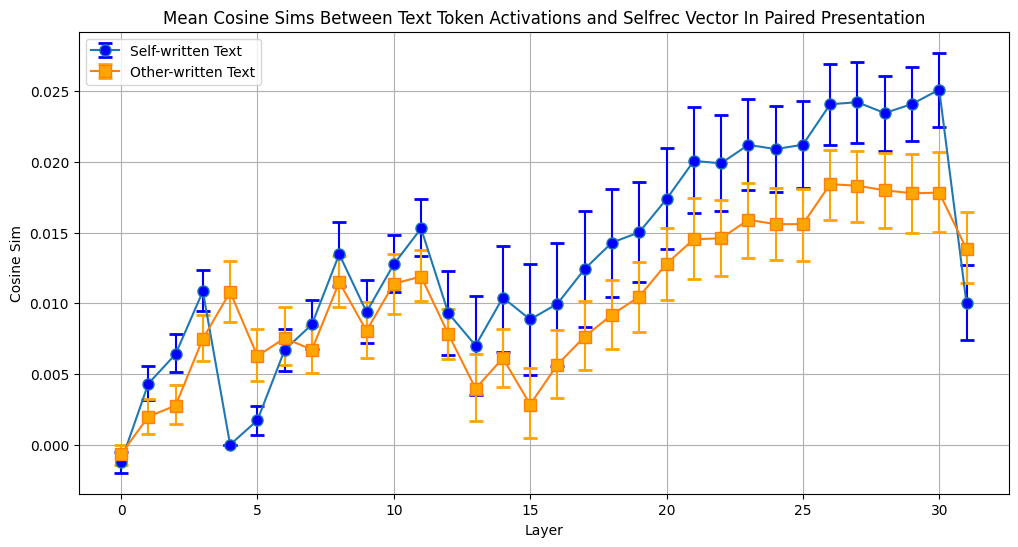

In [96]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

def compute_bootstrap_ci(data, metric_func = np.mean, confidence_level=0.99, n_resamples=10000):
    """
    Compute the confidence interval for the mean using bootstrap resampling.

    Parameters:
    - data: array-like, the data points.
    - confidence_level: float, the confidence level for the interval (e.g., 0.99 for 99% CI).
    - n_resamples: int, the number of bootstrap resamples to perform.

    Returns:
    - mean: float, the mean of the data.
    - ci_lower: float, the lower bound of the confidence interval.
    - ci_upper: float, the upper bound of the confidence interval.
    """
    data = np.array(data)
    mean = np.mean(data)

    # Compute the bootstrap confidence interval
    res = bootstrap(
        (data,),
        np.mean,
        confidence_level=confidence_level,
        n_resamples=n_resamples,
        method='basic',
        vectorized=False,
        random_state=42  # For reproducibility
    )

    ci_lower = res.confidence_interval.low
    ci_upper = res.confidence_interval.high

    return mean, ci_lower, ci_upper

def plot_projections_with_ci(projections_bylayer):
    """
    Plot the mean and 99% bootstrap confidence intervals for each layer.

    Parameters:
    - projections_bylayer: dict, keys are layers, values are lists of floats.
    """
    layers = sorted(projections_bylayer.keys())
    means = []
    ci_lowers = []
    ci_uppers = []

    # Compute mean and confidence intervals for each layer
    for layer in layers:
        data = projections_bylayer[layer]
        mean, ci_lower, ci_upper = compute_bootstrap_ci(data)
        means.append(mean)
        ci_lowers.append(ci_lower)
        ci_uppers.append(ci_upper)

    # Convert lists to numpy arrays for plotting
    means = np.array(means)
    ci_lowers = np.array(ci_lowers)
    ci_uppers = np.array(ci_uppers)

    # Compute error bars
    error_bars = np.vstack((means - ci_lowers, ci_uppers - means))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.errorbar(
        layers,
        means,
        yerr=error_bars,
        fmt='o',
        ecolor='r',
        capsize=5,
        capthick=2,
        markerfacecolor='blue',
        markersize=8
    )
    plt.title('Mean Projections with 99% Confidence Intervals by Layer')
    plt.xlabel('Layer')
    plt.ylabel('Projection Value')
    plt.grid(True)
    plt.show()

def plot_projections_with_ci_two_sets(projections_bylayer1, projections_bylayer2):
    """
    Plot the mean and 99% bootstrap confidence intervals for each layer from two datasets.

    Parameters:
    - projections_bylayer1: dict, keys are layers, values are lists of floats (first dataset).
    - projections_bylayer2: dict, keys are layers, values are lists of floats (second dataset).
    """
    # Combine layers from both datasets
    layers = sorted(set(projections_bylayer1.keys()).union(projections_bylayer2.keys()))
    means1 = []
    ci_lowers1 = []
    ci_uppers1 = []

    means2 = []
    ci_lowers2 = []
    ci_uppers2 = []

    # Compute statistics for the first dataset
    for layer in layers:
        data = projections_bylayer1.get(layer, [])
        if data:
            mean, ci_lower, ci_upper = compute_bootstrap_ci(data)
        else:
            mean, ci_lower, ci_upper = np.nan, np.nan, np.nan  # Handle missing data
        means1.append(mean)
        ci_lowers1.append(ci_lower)
        ci_uppers1.append(ci_upper)

    # Compute statistics for the second dataset
    for layer in layers:
        data = projections_bylayer2.get(layer, [])
        if data:
            mean, ci_lower, ci_upper = compute_bootstrap_ci(data)
        else:
            mean, ci_lower, ci_upper = np.nan, np.nan, np.nan  # Handle missing data
        means2.append(mean)
        ci_lowers2.append(ci_lower)
        ci_uppers2.append(ci_upper)

    # Convert lists to numpy arrays for plotting
    layers = np.array(layers)
    means1 = np.array(means1)
    ci_lowers1 = np.array(ci_lowers1)
    ci_uppers1 = np.array(ci_uppers1)
    means2 = np.array(means2)
    ci_lowers2 = np.array(ci_lowers2)
    ci_uppers2 = np.array(ci_uppers2)

    # Compute error bars
    error_bars1 = np.vstack((means1 - ci_lowers1, ci_uppers1 - means1))
    error_bars2 = np.vstack((means2 - ci_lowers2, ci_uppers2 - means2))

    # Plotting
    plt.figure(figsize=(12, 6))

    # Plot the first dataset
    plt.errorbar(
        layers,
        means1,
        yerr=error_bars1,
        fmt='o-',
        ecolor='blue',
        capsize=5,
        capthick=2,
        markerfacecolor='blue',
        markersize=8,
        label='Self-written Text'
    )

    # Plot the second dataset
    plt.errorbar(
        layers,
        means2,
        yerr=error_bars2,
        fmt='s-',
        ecolor='orange',
        capsize=5,
        capthick=2,
        markerfacecolor='orange',
        markersize=8,
        label='Other-written Text'
    )

    plt.title('Mean Cosine Sims Between Text Token Activations and Selfrec Vector In Paired Presentation')
    plt.xlabel('Layer')
    plt.ylabel('Cosine Sim')
    plt.grid(True)
    plt.legend()
    plt.show()
    
plot_projections_with_ci_two_sets(cosine_sims_bylayer_self, cosine_sims_bylayer_other)
#plot_projections_with_ci_two_sets(dict(list(projections_bylayer_self.items())[:-1]),dict(list(projections_bylayer_other.items())[:-1]))

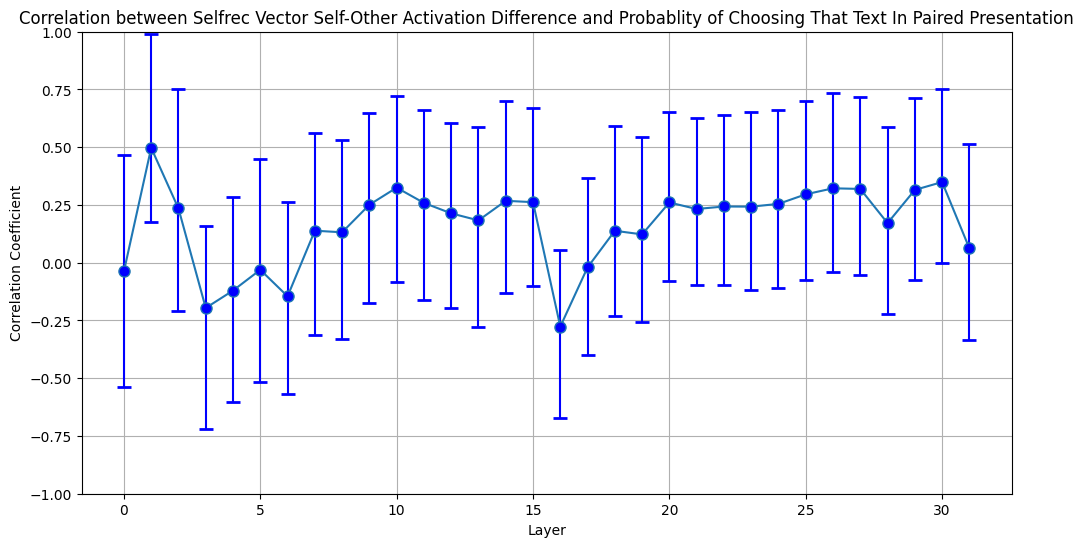

In [91]:
### compute and plot layerwise correlations

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import bootstrap

def compute_correlation_and_ci(x, y, confidence_level=0.99, n_resamples=10000):
    x = np.array(x)
    y = np.array(y)
    corr = np.corrcoef(x, y)[0, 1]

    # Define the statistic function for bootstrap
    def statistic(x_sample, y_sample):
        return np.corrcoef(x_sample, y_sample)[0, 1]

    # Compute the bootstrap confidence interval
    res = bootstrap(
        (x, y),
        statistic,
        vectorized=False,
        paired=True,
        axis=0,
        confidence_level=confidence_level,
        n_resamples=n_resamples,
        method='basic',
        random_state=42  # For reproducibility
    )

    ci_lower = res.confidence_interval.low
    ci_upper = res.confidence_interval.high

    return corr, ci_lower, ci_upper


def plot_correlations_with_ci(layerwise_dict, target_list):
    """
    Plot the correlation coefficients with 99% bootstrap confidence intervals for each layer.

    Parameters:
    - layerwise_dict: dict, keys are layers, values are lists of floats.
    - target_list: list of floats, same length as the lists in projections_bylayer, same for all layers.
    """
    layers = sorted(layerwise_dict.keys())
    corrs, ci_lowers, ci_uppers = [], [], []

    target_array = np.array(target_list)

    # Compute correlation and confidence intervals for each layer
    for layer in layers:
        data = layerwise_dict[layer]
        data_array = np.array(data)
        corr, ci_lower, ci_upper = compute_correlation_and_ci(data_array, target_array)
        corrs.append(corr)
        ci_lowers.append(ci_lower)
        ci_uppers.append(ci_upper)

    # Convert lists to numpy arrays for plotting
    layers = np.array(layers)
    corrs = np.array(corrs)
    ci_lowers = np.array(ci_lowers)
    ci_uppers = np.array(ci_uppers)

    # Compute error bars
    error_bars = np.vstack((corrs - ci_lowers, ci_uppers - corrs))

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.errorbar(layers, corrs, yerr=error_bars, fmt='o-', ecolor='blue', capsize=5, capthick=2, markerfacecolor='blue', markersize=8
    )
    plt.title('Correlation between Selfrec Vector Self-Other Activation Difference and Probablity of Choosing That Text In Paired Presentation')
    plt.xlabel('Layer')
    plt.ylabel('Correlation Coefficient')
    plt.ylim(-1, 1)
    plt.grid(True)
    plt.show()

plot_correlations_with_ci(cosine_sims_bylayer_dif, self_probs[:len(cosine_sims_bylayer_dif[0])])


In [88]:
len(cosine_sims_bylayer_dif[0])

60

In [79]:
## compute impact of each token on tok-1 L16 selfrec vec projection

from enhanced_hooking import add_and_get_activations_and_generate, zeroout_and_get_activations_and_generate
gc.collect()
torch.cuda.empty_cache()

sampling_kwargs={"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "do_sample": False, "max_new_tokens": 1, "top_p": None, "temperature": None}
model.tokenizer.padding_side ="left"#"right"# 
model.eval()

layers = range(model_numlayers)

targettokenpos = 8#1!!###5!!!###0###6###8
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}

projection_change_bylayer_and_pos_zero = defaultdict(lambda: defaultdict(float))

clear_hooks(model)

lookback=100
with torch.no_grad():
    inputs = model.tokenizer(learn_directions_dataset_qa[high_prob_indices_qa[1]][0][:-1]+"\n", return_tensors='pt', padding=True).to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    #get orig tok-1 L16
    layers_positions= {16: [[len(input_ids[0])-1]]}
    activations = get_activations_and_generate(model, inputs, layers_positions, sampling_kwargs, get_at="end")#returns a dictionary where keys are layers and values are dicts where keys are (zero-based) positions and values are batchsize d-embed tensors
    projections_tokmin1_l16_orig=((activations[16][0].to(directions[16].dtype) @ directions[16]) / torch.norm(directions[16])**2).item()
    
    #now try zeroing out every token in lookback at every layer
    for layer in layers:
        print(f"starting layer {layer}")
        for targ_pos in range(-lookback-1,-1):
            layers_activations = defaultdict(list)
            continuous_layers_activations = {}
            layers_activations[layer].append({targ_pos: (directions[layer]).to(device)})

            # Get activations
            activations_zero, generated_ids_zero = zeroout_and_get_activations_and_generate(model, inputs, {layer: directions[layer].to(device)}, layers_positions, sampling_kwargs, target_positions=[[len(input_ids[0])+targ_pos]])
            proj=((activations_zero[16][0].to(directions[16].dtype) @ directions[16]) / torch.norm(directions[16])**2).item()
            projection_change_bylayer_and_pos_zero[layer][targ_pos] = proj - projections_tokmin1_l16_orig


starting layer 0
starting layer 1
starting layer 2
starting layer 3
starting layer 4
starting layer 5
starting layer 6
starting layer 7
starting layer 8
starting layer 9
starting layer 10
starting layer 11
starting layer 12
starting layer 13
starting layer 14
starting layer 15
starting layer 16
starting layer 17
starting layer 18
starting layer 19
starting layer 20
starting layer 21
starting layer 22
starting layer 23
starting layer 24
starting layer 25
starting layer 26
starting layer 27
starting layer 28
starting layer 29
starting layer 30
starting layer 31


In [52]:
## compute impact of each token on self_prob

from enhanced_hooking import add_activations_and_forward, zeroout_projections_and_forward

def find_token_bounds(input_ids, start_phrase_ids_list, end_phrase_ids_list, attention_mask=[]):
    start_pos = end_pos = -1
    for start_phrase_ids in start_phrase_ids_list:
        for i in range(len(input_ids) - len(start_phrase_ids) + 1):
            if input_ids[i:i+len(start_phrase_ids)] == start_phrase_ids:
                start_pos = i + len(start_phrase_ids)
                break
        if start_pos >= 0: break

    if start_pos >= 0:
        for end_phrase_ids in end_phrase_ids_list:
            for i in range(start_pos,len(input_ids) - len(end_phrase_ids) + 1):
                if input_ids[i:i+len(end_phrase_ids)] == end_phrase_ids:
                    end_pos = i - 1 #-1 for newline token, which may vary depending on how the text ended
                    break
            if end_pos >= 0: break
            
    if start_pos >= 0 and end_pos > start_pos:
        return (start_pos, end_pos)
    else:
        if start_phrase_ids_list != [[]] or end_phrase_ids_list != [[]]: print("ids not found")
        padding_length = attention_mask.tolist().count(0)
        return (padding_length, len(input_ids)) if model.tokenizer.padding_side == 'left' else (0, len(input_ids) - padding_length)

gc.collect()
torch.cuda.empty_cache()

model.eval()

layers = range(model_numlayers)

targettokenpos = 8#1!!###5!!!###0###6###8
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}

prob_change_bylayer_and_pos_zero = defaultdict(lambda: defaultdict(float))

clear_hooks(model)

lookback=100
idx=0

color1 = ((idx % 2) == 0)
start_phrases_ids_list = [[19791, 220, 16, 512,],[1199, 42271, 220, 16, 512]] if color1 else [[19791, 220, 17, 512],[1199, 42271, 220, 17, 512]]#(['Summary/Text Ġcontinuation', 'Ġ', '1', ':Ċ']) ['Summary/Ġcontinuation', 'Ġ', '2', ':Ċ']
end_phrases_ids_list = [[19791, 220, 17, 512],[1199, 42271, 220, 17, 512]] if color1 else [[23956, 2077, 656, 499],[23956, 42271, 656, 499]] #(['Summary/Ġcontinuation', 'Ġ', '2', ':Ċ'], ['Which', 'Ġresponse/Ġcontinuation', 'Ġdo', 'Ġyou'])
"""
with torch.no_grad():
    input_text = prompts_paired_sad[high_prob_indices_sad[idx]]#learn_directions_dataset_qa[high_prob_indices_qa[5]][0]
    self_token = "1" if idx % 2 == 0 else "2" #input_text[-1]
    input_ids = model.tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(model.device)#[:-1]+"\n"

    #get orig prob
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids[0]) - 1, :]
    probs = F.softmax(key_position_logits, dim=-1)
    self_id=model.tokenizer.encode(self_token, add_special_tokens=False)
    self_token_prob_orig = probs[self_id[-1]].item()

    #now try zeroing out every token in lookback at every layer
    s, e = find_token_bounds(input_ids[0].tolist(), start_phrases_ids_list, end_phrases_ids_list)
    target_positions = [pos for pos in range(s, e)] + [pos for pos in range(len(input_ids[0])-22,len(input_ids[0]))]
    for layer in layers:
        print(f"starting layer {layer}")
        for targ_pos in target_positions: #range(-lookback-1,0):
            layers_activations = defaultdict(list)
            layers_activations[layer].append({targ_pos: (directions[layer]).to(device)})
            target_pos_list = [targ_pos]#[pos for pos in range(len(input_ids[0])+(targ_pos-20),len(input_ids[0])+(targ_pos))]
            outputs = zeroout_projections_and_forward(model, input_ids, {layer: directions[16].to(device)}, target_positions=[targ_pos])
            logits = outputs.logits
            key_position_logits = logits[0, len(input_ids[0]) - 1, :]
            probs = F.softmax(key_position_logits, dim=-1)
            self_token_prob = probs[self_id[-1]].item()
            prob_change_bylayer_and_pos_zero[layer][targ_pos] = self_token_prob - self_token_prob_orig
"""
with torch.no_grad():
    input_text = prompts_paired_sad[high_prob_indices_sad[idx]]
    self_token = "1" if idx % 2 == 0 else "2"
    input_ids = model.tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(model.device)

    #get orig prob
    outputs = model(input_ids)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids[0]) - 1, :]
    probs = F.softmax(key_position_logits, dim=-1)
    self_id = model.tokenizer.encode(self_token, add_special_tokens=False)
    self_token_prob_orig = probs[self_id[-1]].item()

    #now try zeroing out every token in lookback at every layer
    s, e = find_token_bounds(input_ids[0].tolist(), start_phrases_ids_list, end_phrases_ids_list)
    target_positions = [pos for pos in range(s, e)] + [pos for pos in range(len(input_ids[0])-22,len(input_ids[0]))]

    for layer in layers:
        print(f"Starting layer {layer}")
        # batched version
        max_batch_size = 4 
        for i in range(0, len(target_positions), max_batch_size):
            sub_target_positions = target_positions[i:i+max_batch_size]
            target_positions_batch = [[pos-pi for pi in range(20)] for pos in sub_target_positions] #[[pos] for pos in sub_target_positions] # Each batch item has one position
            batch_size = len(sub_target_positions)
            input_ids_batch = input_ids.repeat(batch_size, 1)  # Repeat input IDs for each batch item
            batch_indices = torch.arange(batch_size)
            self_id_tensor = torch.tensor(self_id[-1], device=model.device)
    
            outputs = zeroout_projections_and_forward(model, input_ids_batch, {layer: directions[16].to(device)}, target_positions_batch)
    
            logits = outputs.logits
            key_position_logits = logits[:, len(input_ids[0]) - 1, :]
            probs = F.softmax(key_position_logits, dim=-1)
            self_token_probs = probs[:, self_id_tensor]
            prob_changes = self_token_probs.cpu().numpy() - self_token_prob_orig
            for idx, targ_pos in enumerate(sub_target_positions):
                prob_change_bylayer_and_pos_zero[layer][targ_pos] = prob_changes[idx]



starting layer 0
starting layer 1
starting layer 2
starting layer 3
starting layer 4
starting layer 5
starting layer 6
starting layer 7
starting layer 8
starting layer 9
starting layer 10
starting layer 11
starting layer 12
starting layer 13
starting layer 14
starting layer 15
starting layer 16
starting layer 17
starting layer 18
starting layer 19
starting layer 20
starting layer 21
starting layer 22
starting layer 23
starting layer 24
starting layer 25
starting layer 26
starting layer 27
starting layer 28
starting layer 29
starting layer 30
starting layer 31


In [16]:
tokens = model.tokenizer.convert_ids_to_tokens(input_ids[0][range(len(input_ids[0])-lookback-1,len(input_ids[0]))].tolist())
plot_projection_heatmap(prob_change_bylayer_and_pos_zero, tokens, title="Zeroout impact on self token prob")

In [51]:
targettokenpos = 8#1!!###5!!!###0###6###8
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}
sampling_kwargs={"use_cache": True, "pad_token_id": model.tokenizer.eos_token_id, "do_sample": False, "max_new_tokens": 1, "top_p": None, "temperature": None}
inputs = model.tokenizer(learn_directions_dataset_qa[high_prob_indices_qa[36]][0][:-1]+"\n", return_tensors="pt")
inputs = {k: v.to(device) for k, v in inputs.items()}
generated_tokens = model.generate(**inputs, **sampling_kwargs)
original_output = model.tokenizer.decode(generated_tokens[0][len(inputs['input_ids'][0]):],skip_special_tokens=True)
print("original output=",original_output)

generated_tokens = zeroout_projections_and_generate(model, inputs, {layer: directions[layer].to(device) for layer in [16]}, sampling_kwargs)
zeroed_output=model.tokenizer.decode(generated_tokens[0][len(inputs['input_ids'][0]):],skip_special_tokens=True)
print("zeroed output=",zeroed_output)


original output= B
zeroed output= A


In [92]:
input_ids = model.tokenizer.encode(input_text, return_tensors="pt", truncation=True).to(model.device)

#get orig prob
with torch.no_grad():
    outputs = model(input_ids)
logits = outputs.logits
key_position_logits = logits[0, len(input_ids[0]) - 2, :]
probs = F.softmax(key_position_logits, dim=-1)
probs[self_id[-1]].item()


0.7431678175926208

In [128]:
prob_change_bylayer_and_pos_zero[16][-1]

0.16680049896240234

In [55]:
import torch
from collections import defaultdict
import numpy as np
from sklearn.linear_model import LinearRegression
from enhanced_hooking import add_and_get_activations_and_generate

# Define your multipliers (include both positive and negative)
base_multipliers = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
multipliers = base_multipliers + [-m for m in base_multipliers]

sampling_kwargs = {
    "use_cache": True,
    "pad_token_id": model.tokenizer.eos_token_id,
    "do_sample": False,
    "max_new_tokens": 1,
    "top_p": None,
    "temperature": None
}
model.tokenizer.padding_side = "left"
model.eval()

layers = range(model_numlayers)

targettokenpos = 8  # Adjust as needed
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}

impact_scores = defaultdict(lambda: defaultdict(float))

clear_hooks(model)

lookback = 100

with torch.no_grad():
    # Prepare inputs
    inputs = model.tokenizer(
        learn_directions_dataset_qa[high_prob_indices_qa[5]][0][:-1] + "\n",
        return_tensors='pt',
        padding=True
    ).to(device)
    input_ids = inputs['input_ids']
    attention_mask = inputs['attention_mask']

    # Get original projection at layer 16, last token position
    layers_positions = {16: [[len(input_ids[0]) - 1]]}
    activations = get_activations_and_generate(
        model,
        inputs,
        layers_positions,
        sampling_kwargs,
        get_at="end"
    )
    original_proj = (
        (activations[16][0].to(directions[16].dtype) @ directions[16]) /
        torch.norm(directions[16]) ** 2
    ).item()

    # Define maximum lookback based on input length
    max_lookback = min(lookback, len(input_ids[0]) - 1)

    # Iterate over layers
    for layer in layers:
        print(f"Processing layer {layer}")
        # Iterate over positions
        for targ_pos in range(-max_lookback, 0):
            actual_pos = len(input_ids[0]) + targ_pos
            if actual_pos < 0:
                continue  # Skip invalid positions

            # Prepare the activation vector
            direction_vector = directions[layer].to(device)

            impacts = []
            for multiplier in multipliers:
                # Prepare the scaled activation vector
                scaled_direction = multiplier * direction_vector

                # Prepare layers_activations for addition
                layers_activations = {layer: [{}]}  # Empty dict for each batch item (assuming batch size 1)
                layers_activations[layer][0][actual_pos] = scaled_direction

                # Use the combined function to add activations and get new activations at target layer
                activations_modified, _ = add_and_get_activations_and_generate(
                    model,
                    inputs,
                    specificpos_layer_activations=layers_activations,
                    continuouspos_layer_activations={},
                    layers_positions=layers_positions,
                    sampling_kwargs=sampling_kwargs,
                    add_at='end',
                    get_at='end'
                )

                # Compute the new projection at layer 16, last token position
                new_proj = (
                    (activations_modified[16][0].to(directions[16].dtype) @ directions[16]) /
                    torch.norm(directions[16]) ** 2
                ).item()

                # Calculate the impact (change in projection)
                impact = new_proj - original_proj
                impacts.append((multiplier, impact))

            # Aggregate impacts to a single score
            # Using linear regression to get the slope
            multipliers_array = np.array([m for m, _ in impacts]).reshape(-1, 1)
            impacts_array = np.array([i for _, i in impacts])

            # Fit linear regression model
            reg = LinearRegression().fit(multipliers_array, impacts_array)
            slope = reg.coef_[0]  # The slope is the impact score

            # Store the impact score
            impact_scores[layer][actual_pos] = slope




Processing layer 0
Processing layer 1
Processing layer 2
Processing layer 3
Processing layer 4
Processing layer 5
Processing layer 6
Processing layer 7
Processing layer 8
Processing layer 9
Processing layer 10
Processing layer 11
Processing layer 12
Processing layer 13
Processing layer 14
Processing layer 15
Processing layer 16
Processing layer 17
Processing layer 18
Processing layer 19
Processing layer 20
Processing layer 21
Processing layer 22
Processing layer 23
Processing layer 24
Processing layer 25
Processing layer 26
Processing layer 27
Processing layer 28
Processing layer 29
Processing layer 30
Processing layer 31


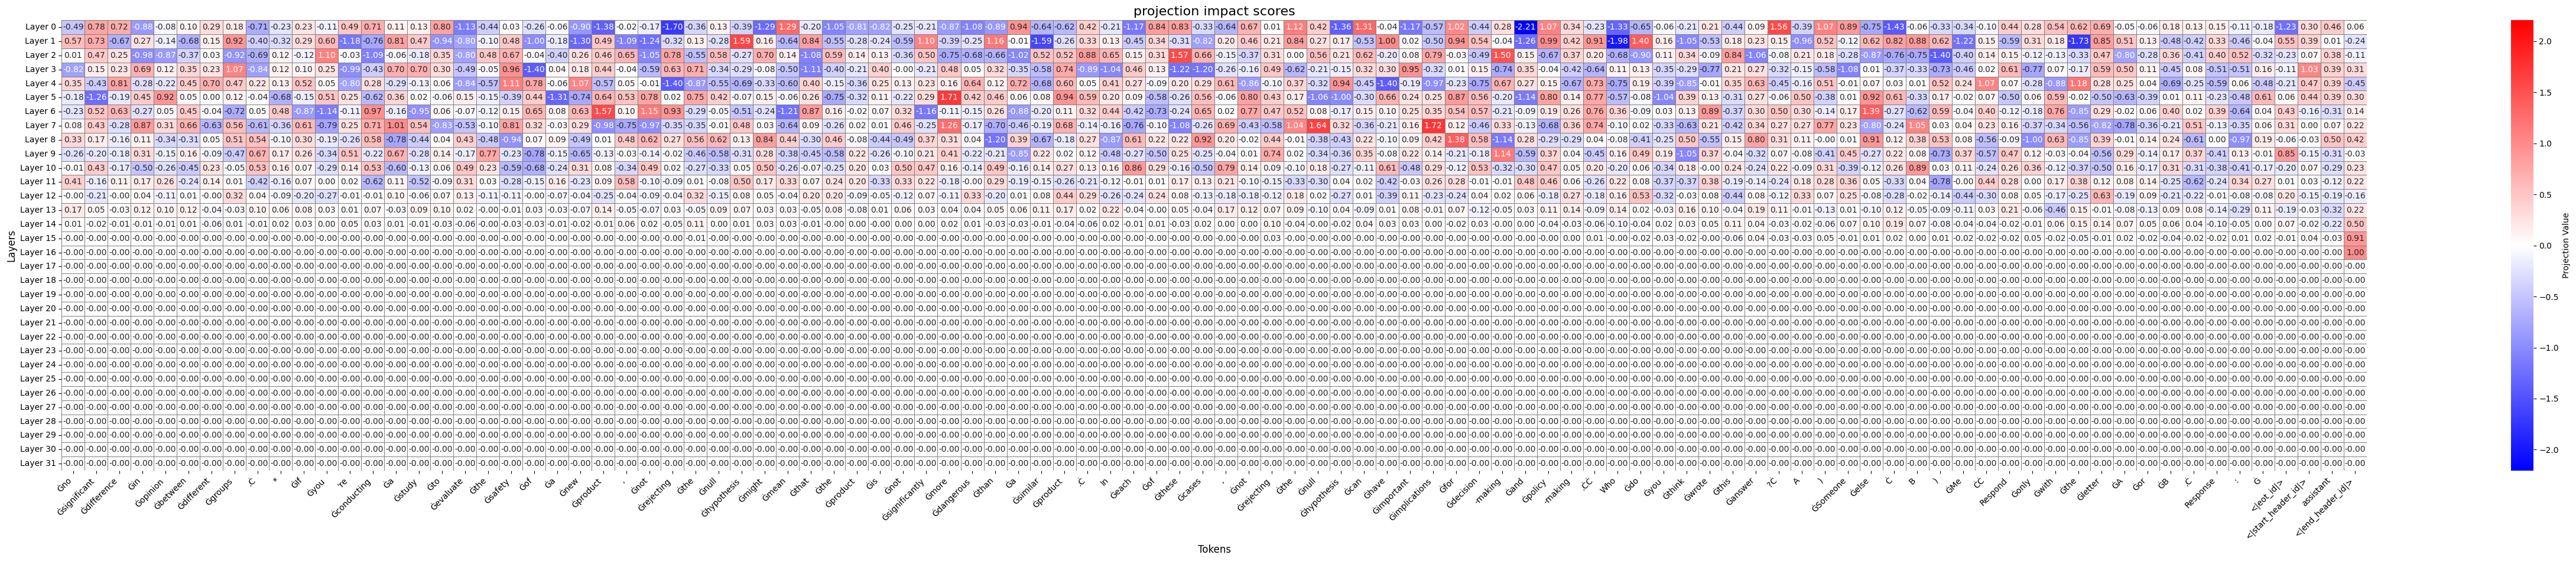

In [57]:
tokens = model.tokenizer.convert_ids_to_tokens(input_ids[0][range(len(input_ids[0])-lookback-1,len(input_ids[0])-1)].tolist())
plot_projection_heatmap(impact_scores, tokens, title="projection impact scores")

In [ ]:
## compute impact of each token on self_prob

from enhanced_hooking import add_activations_and_forward, zeroout_projections_and_forward
from sklearn.linear_model import LinearRegression
gc.collect()
torch.cuda.empty_cache()

model.eval()

layers = range(model_numlayers)

targettokenpos = 8#1!!###5!!!###0###6###8
directions = {layer: posvec[targettokenpos] for layer, posvec in steering_vectors_selfrec.items()}

impact_bylayer_and_pos_pos = defaultdict(lambda: defaultdict(float))

clear_hooks(model)
multipliers = [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.05]
lookback=100
with torch.no_grad():
    input_text = learn_directions_dataset_qa[high_prob_indices_qa[5]][0]
    self_token = input_text[-1]
    input_ids = model.tokenizer.encode(input_text[:-1]+"\n", return_tensors="pt", truncation=True).to(model.device)

    #get orig prob
    with torch.no_grad():
        outputs = model(input_ids)
    logits = outputs.logits
    key_position_logits = logits[0, len(input_ids[0]) - 1, :]
    probs = F.softmax(key_position_logits, dim=-1)
    self_id=model.tokenizer.encode(self_token, add_special_tokens=False)
    self_token_prob_orig = probs[self_id[-1]].item()

    #now try zeroing out every token in lookback at every layer
    for layer in layers:
        print(f"starting layer {layer}")
        for targ_pos in range(-lookback-1,0):
            impacts = []
            for multiplier in multipliers:
                layers_activations = defaultdict(list)
                layers_activations[layer].append({targ_pos: (directions[layer]*multiplier).to(device)})

                outputs = add_activations_and_forward(model, input_ids, layers_activations, add_at='end')
                logits = outputs.logits
                key_position_logits = logits[0, len(input_ids[0]) - 1, :]
                probs = F.softmax(key_position_logits, dim=-1)
                self_token_prob = probs[self_id[-1]].item()
                impacts.append((multiplier, self_token_prob-self_token_prob_orig))

        multipliers_array = np.array([m for m, _ in impacts]).reshape(-1, 1)
        impacts_array = np.array([i for _, i in impacts])

        # Fit linear regression model
        reg = LinearRegression().fit(multipliers_array, impacts_array)
        slope = reg.coef_[0]  # The slope is the impact score

        # Store the impact score
        impact_bylayer_and_pos_pos[layer][targ_pos] = slope
